In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Plot

In [95]:
def load_feature_file(file_path,name_filter,dendrite=False):
    # read axonal feature table
    feature_input=pd.read_csv(file_path,sep=" ",header=None)
    if dendrite==False:
        feature_input.columns=['name','arbor_id','region','max_density','num_nodes','total_path_length','volume','branch','d_to_soma','d_to_soma2','hub','variance_ratio']
    else:
        feature_input.columns=['name','region','max_density','nodes','p_length','volume','branch','d_to_soma','d_to_soma2','hub','variance_ratio']
    feature_table=feature_input[feature_input['name'].isin(name_filter)]
    feature_table=feature_table.reset_index(drop=True)
    return feature_table

def arbor_category(feature_table,info_table,LD_threshold,dendrite=False):
    ### arbor order: A1,A2,A3 (based on distance to soma)--> 0,1,2
    ### LD_marker: local or distal--> 0,1
    arbor_order=[0 for i in range(len(feature_table))]
    LD_marker=[0 for i in range(len(feature_table))]
    ptype=['0' for i in range(len(feature_table))]
    layer_info=['0' for i in range(len(feature_table))]
    stype=['0' for i in range(len(feature_table))]
    
    ### neuron name ID list
    namelist=list(feature_table['name'].drop_duplicates(inplace=False))
    for i in namelist:
        row_id=info_table[info_table['Name']==i].index[0]
        p=info_table['Subclass_or_type'][row_id]
        l=info_table['Cortical_layer'][row_id]
        s=info_table['Soma_region'][row_id]
        if dendrite == True:
            line_id=feature_table[feature_table['name']==i].index[0]
            ptype[line_id]=p
            layer_info[line_id]=l
            stype[line_id]=s
        else:
            d=list(feature_table[feature_table['name']==i]['d_to_soma2']).copy()
            ai=list(feature_table[feature_table['name']==i]['arbor_id']).copy()
            newD=sorted(d)
            for j in range(len(newD)):
                org_id=d.index(newD[j])
                line_id=feature_table[(feature_table['name']==i)&(feature_table['arbor_id']==ai[org_id])].index[0]
                arbor_order[line_id]=j
                ptype[line_id]=p
                if newD[j]>LD_threshold:
                    LD_marker[line_id]=1
                    
    if dendrite == False:
        return arbor_order, LD_marker, ptype
    else:
        return stype, ptype, layer_info

def count_neuron(subtypes,feature_table,projection=None):
    count=[0 for i in range(len(subtypes))]
    visited_name=[]
    for i in range(len(feature_table)):
        name=feature_table['name'][i]
        stype=feature_table['region'][i]
        if projection == None:
            if stype in subtypes:
                if name in visited_name:
                    continue
                else:
                    visited_name.append(name)
                    ID=subtypes.index(stype)
                    count[ID]=count[ID]+1
        else:
            p=projection[i]
            sp=str(p)+'-'+stype
            if sp in subtypes:
                if name in visited_name:
                    continue
                else:
                    visited_name.append(name)
                    ID=subtypes.index(sp)
                    count[ID]=count[ID]+1
                
    return count            

In [35]:
def Mean_Subtype_Axonal(feature_table,subtypes,num_arbor,cols,arbor_order,LD_marker,ptype,projection=None):
    # table for mean values of each soma type & each arbor type
    table_mean=[]
    
    if projection==None:
        for c in subtypes:
            result=[]
            for j in cols:
                for i in range(num_arbor):
                    lines1=feature_table[(feature_table['region']==c)&(np.array(arbor_order)==i)&(np.array(LD_marker)==0)]
                    lines2=feature_table[(feature_table['region']==c)&(np.array(arbor_order)==i)&(np.array(LD_marker)==1)]
                    if len(lines1)==0:
                        m1=0
                    else:
                        m1=lines1[j].mean()
                    if len(lines2)==0:
                        m2=0
                    else:
                        m2=lines2[j].mean()
                    result.append(m1)
                    result.append(m2)
            table_mean.append(result)
    else: 
        for p in projection:
            for c in subtypes:
                result=[]
                for j in cols:
                    for i in range(num_arbor):
                        m1=feature_table[(feature_table['region']==c)&(np.array(ptype)==p)&(np.array(LD_marker)==0)&(np.array(arbor_order)==i)][j].mean()
                        m2=feature_table[(feature_table['region']==c)&(np.array(arbor_order)==i)&(np.array(LD_marker)==1)&(np.array(ptype)==p)][j].mean()
                        if str(m1)=='nan':
                            m1=0
                        if str(m2)=='nan':
                            m2=0
                        result.append(m1)
                        result.append(m2)
                table_mean.append(result)
    table_mean=np.array(table_mean)
    return table_mean

In [40]:
def Mean_normalization(table_mean,subtypes,num_feature,col_names,interval,devi,num_arbor,num_arbor_type=2):
    table_df=[]
    
    for i in range(num_feature):
        N=num_arbor*num_arbor_type
        max_value=np.max(table_mean[:,(i*N):(i*N+N)])
        min_value=np.min(table_mean[:,(i*N):(i*N+N)])
        for j in range(num_arbor):        
            for k in range(len(subtypes)):
                cur_idx = i*N+j*num_arbor_type
                record0=table_mean[k,cur_idx]
                if record0 == 0:
                    t0=' '
                else:
                    t0='Local'
                scaled0=(record0-min_value)/(max_value-min_value)
                tmp0=[j*interval,subtypes[k],scaled0,t0,col_names[i]]
                record1=table_mean[k,cur_idx+1]
                scaled1=(record1-min_value)/(max_value-min_value)
                if record1 == 0:
                    t1=' '
                else:
                    t1='Distal'
                tmp1=[j*interval+devi,subtypes[k],scaled1,t1,col_names[i]]
                table_df.append(tmp0)
                table_df.append(tmp1)
    df_mat=pd.DataFrame(table_df)
    df_mat.columns=['Level_0','Level_1','scale','arbor_type','feature']
    return df_mat

In [6]:
name_filter=pd.read_csv("0511/Final_names.txt",sep=" ",header=None)
name_filter.columns=['name']
name_filter=list(name_filter['name'])

file_path="2023/axon_feature2.txt"
feature_table=load_feature_file(file_path,name_filter)

# Axonal Arbors: S-Type

In [76]:
info_table = pd.read_csv("2023/1891_type.txt",sep=" ")
LD_threshold = 750

arbor_order, LD_marker, ptype=arbor_category(feature_table,info_table,LD_threshold)

In [8]:
subtypes=['AId','MOp','MOs','RSPv','SSp-bfd','SSp-ll','SSp-m','SSp-n','SSp-ul','SSs','VISp','CP',
       'LGd','LP','MG','SMT','VM','VPL','VPLpc','VPM']
subtypes.reverse()
num_arbor = 3
### feature columns
cols=['branch','volume','max_density']

mean_subtype=Mean_Subtype_Axonal(feature_table,subtypes,num_arbor,cols,arbor_order,LD_marker,ptype)

In [14]:
num_feature= 3
num_arbor = 3
interval = 2
devi = 0.62
col_names=['#branch','volume','max_density']

df_mat_subtype=Mean_normalization(mean_subtype,subtypes,num_feature,col_names,interval,devi,num_arbor)

In [17]:
count_stype=count_neuron(subtypes,feature_table)

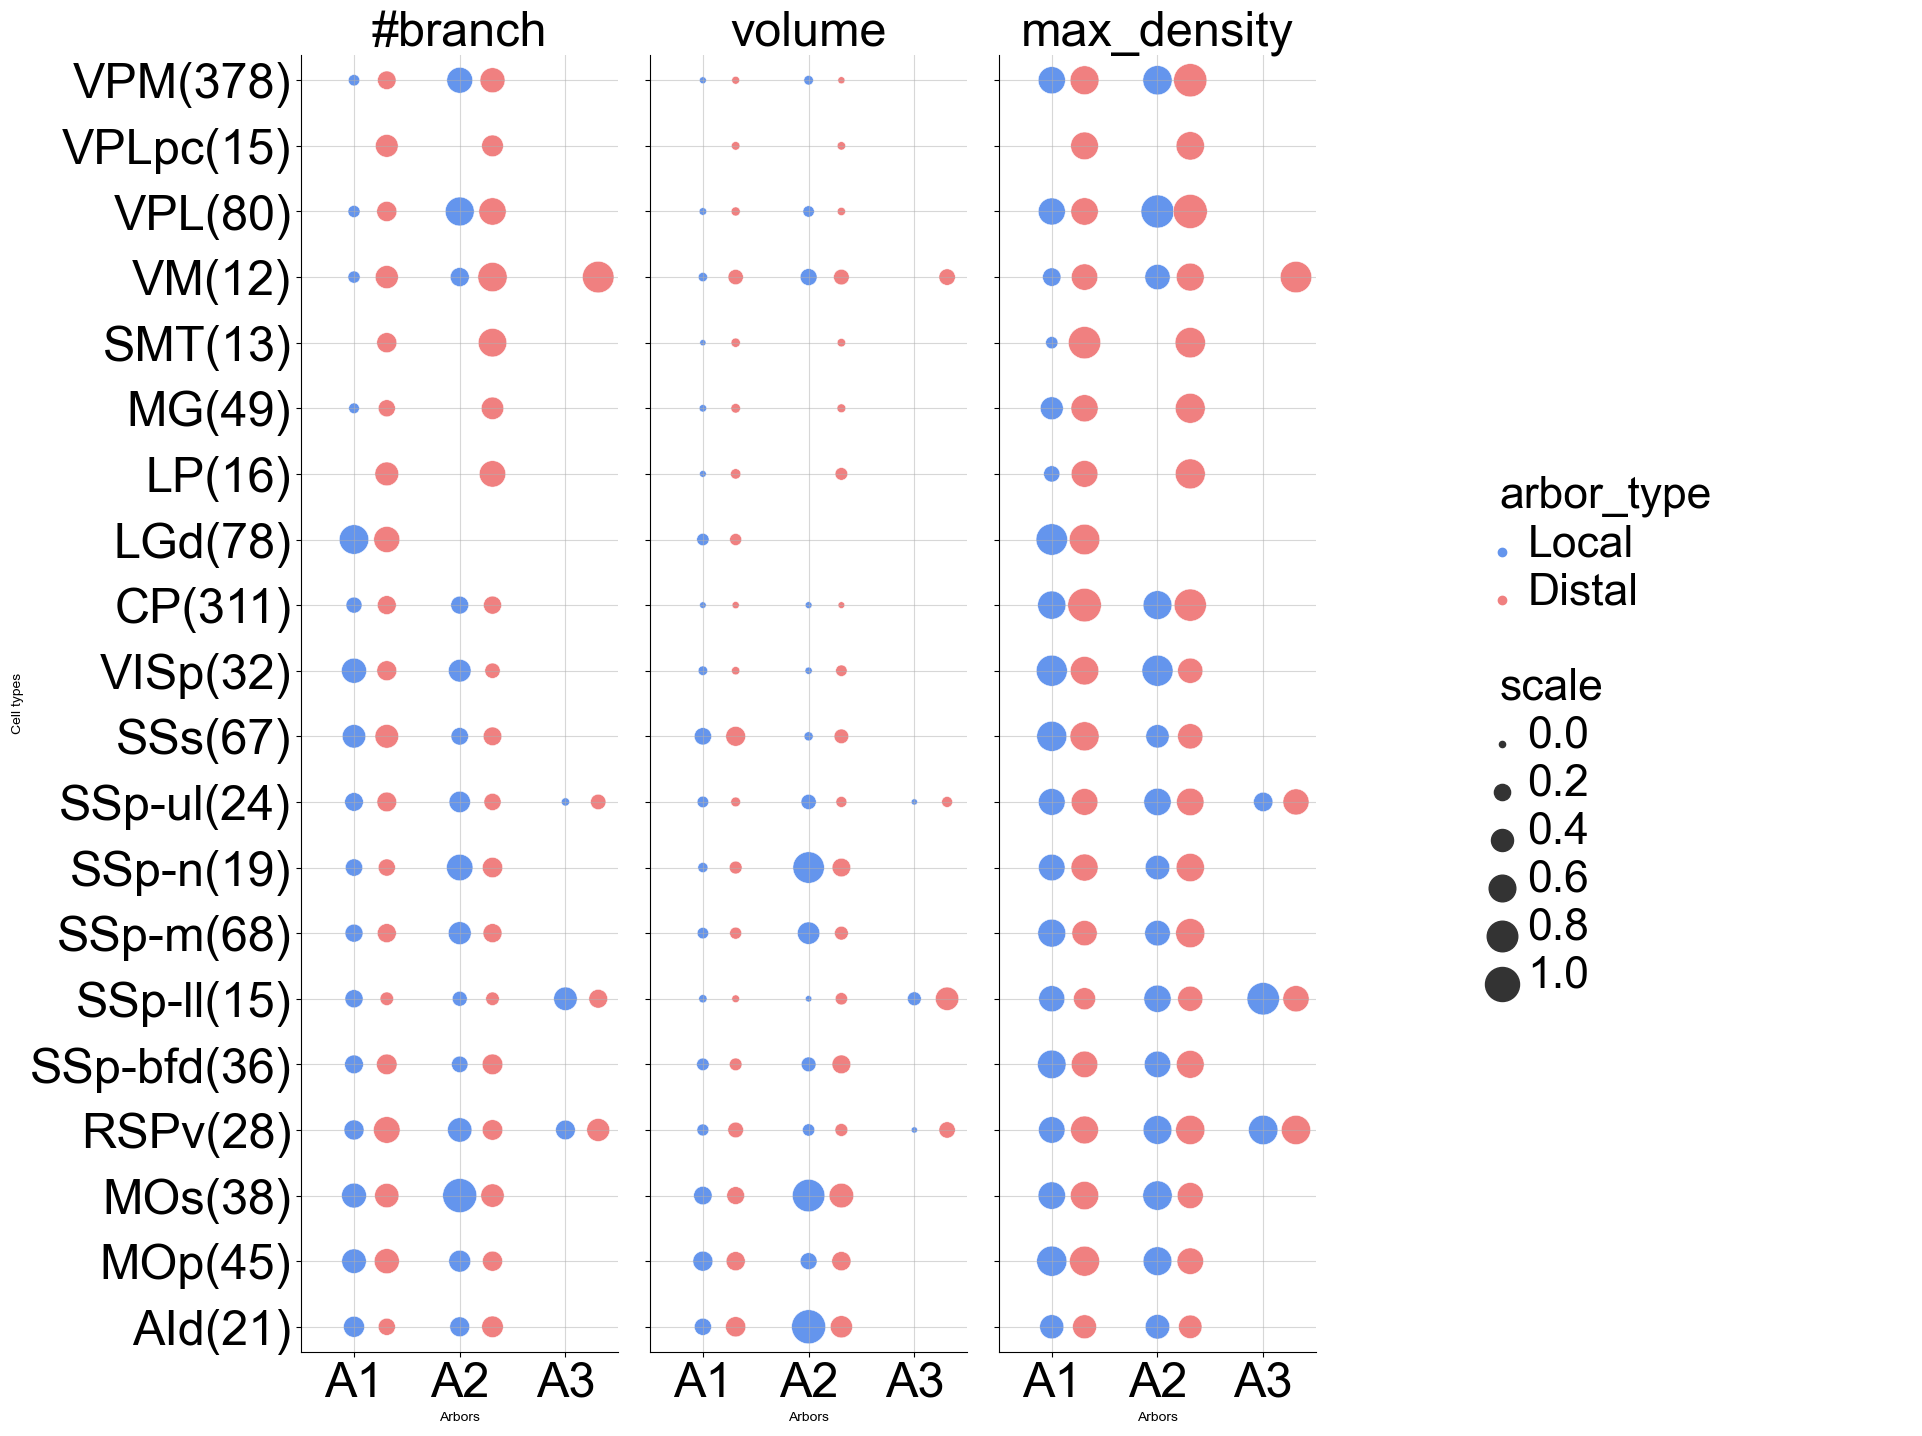

In [19]:
### ' ': does not exist
palette={' ':'w','Local':'cornflowerblue','Distal':'lightcoral'}
### y-axis label: somaType+numArbors
ytickname=[]
for i in range(len(subtypes)):
    name=str(subtypes[i])+'('+str(count_stype[i])+')'
    ytickname.append(name)
ytickname=np.array(ytickname)

plt.rcParams['axes.labelsize']=20
#plt.figure(figsize=(15,13))
g=sns.relplot(data=df_mat_subtype,x="Level_0",y="Level_1",hue="arbor_type",size="scale",col="feature",palette=palette,
             edgecolor="1.",height=14,aspect=0.27,sizes=(20,600),
             )
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(wspace=0.1)
g.sharex=True
plt.setp(g._legend.get_texts(),fontsize=32)
sns.set_theme(style='whitegrid',rc={'legend.labelspacing': 1.3})
g._legend.set_bbox_to_anchor([1.4, 0.5])
g.set(xlabel="Arbors",ylabel="Cell types")
g.set_yticklabels(ytickname)
for i, ax in enumerate(g.axes[0]):
    #ax.set_xlim(-1,3)
    #ax.set_xticks(list(range(3)))
    ax.set_xlim(-1,5)
    ax.set_xticks([0,2,4])
    ax.set_xticklabels(['A1','A2','A3'])
    ax.tick_params(axis='x',labelsize=35)
    ax.tick_params(axis='y',labelsize=35)
    ax.grid("Level_0",alpha=0.5)
    ax.margins(0.02)
    ax.set_title(col_names[i],fontsize=35)
#plt.savefig(f'0511/axonal_arbor_feature.png',bbox_inches='tight',pad_inches=0.1,dpi=600)


# Axonal Arbor: Projection type

In [80]:
p_stype=['SSp-m','SSp-bfd','MOs','MOp']
P=['CTX_IT','CTX_ET']
cols=['branch','volume','max_density']
num_arbor = 2

mean_ptypes=Mean_Subtype_Axonal(feature_table,p_stype,num_arbor,cols,arbor_order,LD_marker,ptype,P)

In [81]:
num_feature= 3
num_arbor = 2
interval = 1.4
devi = 0.53
col_names=['#branch','volume','max_density']
### CTX
ctxnames=['CTX_ET-MOp','CTX_ET-MOs','CTX_ET-SSp-bfd','CTX_ET-SSp-m',
          'CTX_IT-MOp','CTX_IT-MOs','CTX_IT-SSp-bfd','CTX_IT-SSp-m']
ctxnames.reverse()

df_mat_ptype=Mean_normalization(mean_ptypes,ctxnames,num_feature,col_names,interval,devi,num_arbor)

In [77]:
count_sp=count_neuron(ctxnames,feature_table,projection=ptype)

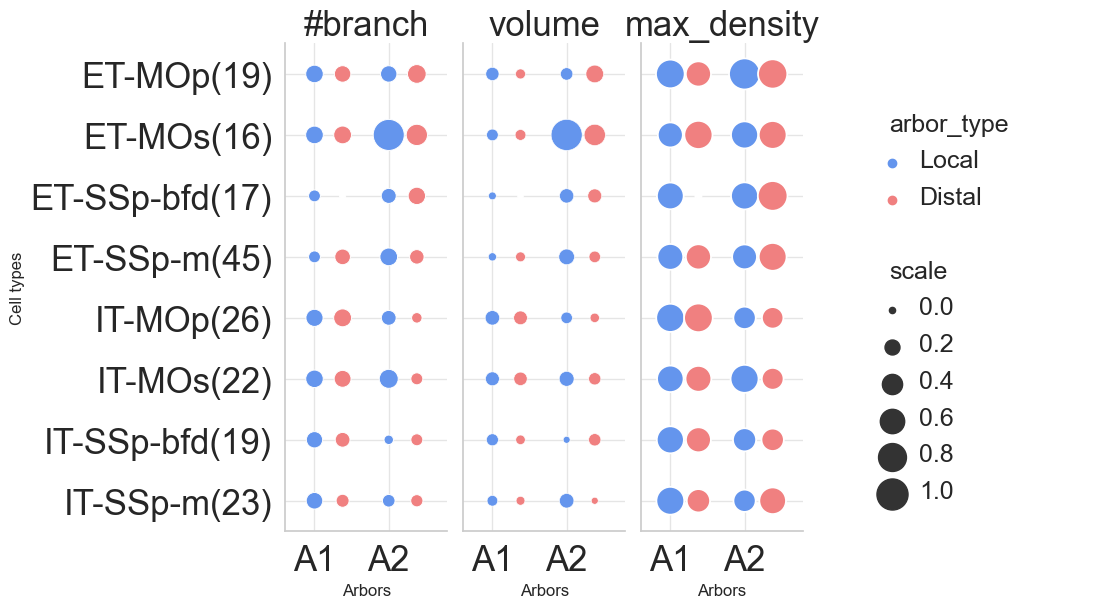

In [82]:
### y-axis names: projection type - soma type (# arbors)
ytickname_sp=[]
ctxtype_display=['ET-MOp','ET-MOs','ET-SSp-bfd','ET-SSp-m',
          'IT-MOp','IT-MOs','IT-SSp-bfd','IT-SSp-m']
ctxtype_display.reverse()
for i in range(len(ctxtype_display)):
    name=str(ctxtype_display[i])+'('+str(count_sp[i])+')'
    ytickname_sp.append(name)

plt.rcParams['axes.labelsize']=20
g=sns.relplot(data=df_mat_ptype,x="Level_0",y="Level_1",hue="arbor_type",size="scale",col="feature",palette=palette,
             edgecolor="1.",height=6,aspect=0.4,sizes=(20,500),legend='brief',
             )
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(wspace=0.1)
g.sharex=True
plt.setp(g._legend.get_texts(),fontsize=18)
g.set(xlabel="Arbors",ylabel="Cell types")
g._legend.set_bbox_to_anchor([1.24, 0.5])
sns.set_theme(style='whitegrid', rc={'legend.labelspacing': 0.9})
g.set_yticklabels(ytickname_sp)
for i, ax in enumerate(g.axes[0]):
    ax.set_xlim(-0.55,2.5)
    ax.set_xticks([0,1.4])
    ax.set_ylim(-0.5,7.5)
    ax.set_xticklabels(['A1','A2'],fontsize=25)
    ax.tick_params(axis='x',labelsize=25)
    ax.tick_params(axis='y',labelsize=25)
    ax.grid("Level_0",alpha=0.5)
    ax.margins(0.02)
    ax.set_title(col_names[i],fontsize=25)  
#plt.savefig(f'0511/axonal_arbor_feature_CTX.png',bbox_inches='tight',pad_inches=0.2,dpi=600)

# Dendritic Arbors

In [86]:
basal_file="2023/basal_feature.txt"
apical_file="2023/apical_feature.txt"
basal_feature_table=load_feature_file(basal_file,name_filter,dendrite=True)
apical_feature_table=load_feature_file(apical_file,name_filter,dendrite=True)

In [96]:
a_stype, a_ptype, a_layer = arbor_category(apical_feature_table,info_table,LD_threshold,dendrite=True)

In [99]:
b_stype, b_ptype, b_layer = arbor_category(basal_feature_table,info_table,LD_threshold,dendrite=True)

In [101]:
def mean_subtype_Dendrite(apicalF,basalF,P,p_stype,a_ptype,b_ptype,cols):
    D_mean=[]
    num_ctx_den =[]
    for p in P:
        for c in p_stype:
            result=[]
            n=len(basalF[(basalF['region']==c)&(np.array(b_ptype)==p)])
            num_ctx_den.append(n)
            for j in cols:
                m1=np.mean(np.array(basalF[(basalF['region']==c)&(np.array(b_ptype)==p)][j]))
                m2=np.mean(np.array(apicalF[(apicalF['region']==c)&(np.array(a_ptype)==p)][j]))
                result.append(m1)
                result.append(m2)
            D_mean.append(result)
    D_mean=np.array(D_mean)
    return D_mean, num_ctx_den

In [104]:
def mean_normalization_dendrite(D_mean,num_den,ctxnames,cols):
    table_D=[]
    for i in range(len(cols)):
        N= num_den
        max_value=np.max(D_mean[:,(i*N):(i*N+N)])
        min_value=np.min(D_mean[:,(i*N):(i*N+N)])
        for j in range(len(ctxnames)):
            cur_idx=i*num_den
            record0 = D_mean[j,cur_idx]
            scaled0=(record0-min_value)/(max_value-min_value)
            if record0 == 0:
                t0=' '
            else:
                t0='basal'
            tmp0=[0,ctxnames[j],scaled0,t0,cols[i]]
            record1 = D_mean[j,cur_idx+1]
            scaled1=(record1-min_value)/(max_value-min_value)
            if record1 == 0:
                t1=' '
            else:
                t1='apical'
            tmp1=[1,ctxnames[j],scaled1,t1,cols[i]]
            table_D.append(tmp0)
            table_D.append(tmp1)
    D_mat=pd.DataFrame(table_D)
    D_mat.columns=['Level_0','Level_1','scale','arbor_type','feature']
    return D_mat

In [102]:
D_mean, D_num= mean_subtype_Dendrite(apical_feature_table,basal_feature_table,P,p_stype,a_ptype,b_ptype,cols)

In [105]:
num_den = 2
cols2 = ['volume','max_density']
D_mat=mean_normalization_dendrite(D_mean,num_den,ctxnames,cols2)

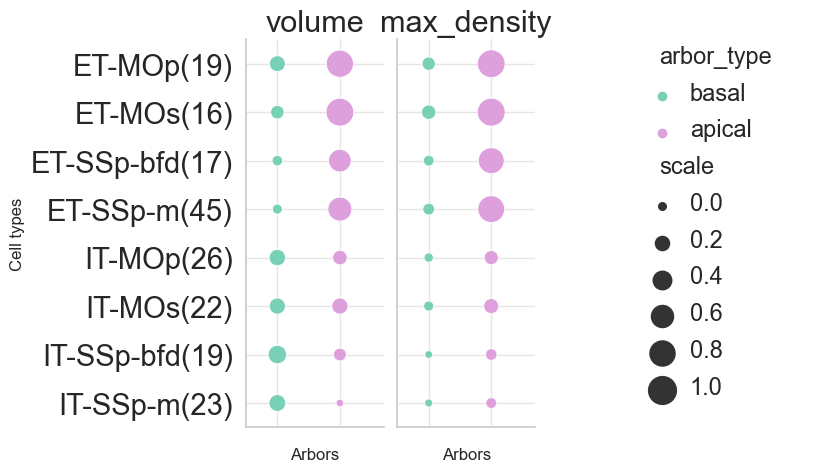

In [107]:
palette2={'basal':'#78d1b6','apical':'plum'}
### y-axis names: projection type - soma type (# dendrite)
ytickname_sp_den=[]
for i in range(len(ctxtype_display)):
    name=str(ctxtype_display[i])+'('+str(D_num[i])+')'
    ytickname_sp_den.append(name)

plt.rcParams['axes.labelsize']=20
g=sns.relplot(data=D_mat,x="Level_0",y="Level_1",hue="arbor_type",size="scale",col="feature",palette=palette2,
             edgecolor="1.",height=5,aspect=0.5,sizes=(30,400),legend='brief',
             )
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(wspace=0.1)
g.sharex=True
plt.setp(g._legend.get_texts(),fontsize=17)
g.set(xlabel="Arbors",ylabel="Cell types")
sns.set_theme(style='whitegrid', rc={'legend.labelspacing': 0.7})
g._legend.set_bbox_to_anchor([1.3, 0.5])
g.set_yticklabels(ytickname_sp_den)
for i, ax in enumerate(g.axes[0]):
    #ax.set_xlim(-1,3)
    #ax.set_xticks(list(range(3)))
    ax.set_xlim(-0.5,1.7)
    ax.set_xticks([0,1])
    ax.set_ylim(-0.5,7.5)
    ax.tick_params(axis='x',colors=(0,0,0,0),labelsize=0)
    ax.tick_params(axis='y',labelsize=21)
    ax.grid("Level_0",alpha=0.5)
    ax.margins(0.02)
    ax.set_title(cols2[i],fontsize=22)
#plt.savefig(f'0511/dendrite_arbor_feature_CTX.png',bbox_inches='tight',pad_inches=0.2,dpi=600)

# Composition of axonal arbors: Local vs Distal

In [109]:
LD_marker=np.array(LD_marker)
axon_stype=np.array(feature_table['region'])

## Local vs Distal
## calculate percentage of local arbor in each soma type
LD_percent=[]
for i in subtypes:
    result=[]
    selected=LD_marker[axon_stype==str(i)]
    total=len(selected)
    D=np.sum(selected)
    L=total-D
    result.append(round(L/total*100,2))
    result.append(round(D/total*100,2))
    LD_percent.append(result)

In [110]:
LD_percent_cum = np.array(LD_percent).cumsum(axis=1)

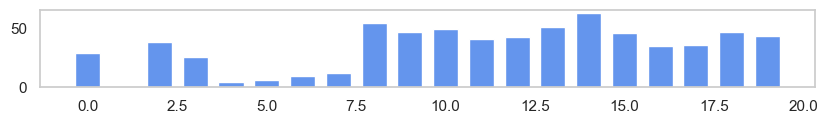

In [111]:
plt.figure(figsize=(10,1))
Y=np.arange(len(LD_percent_cum))
plt.bar(Y, LD_percent_cum[:,0], width=0.7, color='cornflowerblue')
plt.grid(None)
#plt.savefig(f'0511/axonal_LD_percentage.png',bbox_inches='tight',pad_inches=0.2,dpi=600)

In [241]:
### output arbor_order;LD_marker
types=pd.DataFrame({'name':list(feature_table['name']),'arbor_id':list(feature_table['arbor_id']),'stype':list(feature_table['region']),
                    'arbor_order':arbor_order,'LD':LD_marker,'ptype':ptype})
types.to_csv('0511/category.txt',header=True,index=None)